In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from future import GenericFuture
from curve import CommodityCurve

In [7]:
filename = "../data/MultipleTestData.xlsx"

co_tickers = {"Brent": "ICE_B", "WTI": "CME_CL", "Wheat": "CME_W",
              "Corn": "CME_C", "Copper": "CME_HG", "Lead": "MCX_PB",
              "Aluminium": "CME_ALI", "Gas": "CME_NG", "Hogs": "CME_LN",
              "Coffee": "ICE_KC", "Cotton": "ICE_CT", "Cocoa": "ICE_CC",
              "Sugar": "ICE_SB", "HeatOil": "CME_HO", "Gasoline": "CME_RB",
              "Lumber": "CME_LB", "NaturalGas": "CME_NG", "Gold": "CME_GC",
              "Platinum": "CME_PL", "AUD": "CME_AD", "ZAR": "CME_RA", "NOK": "CME_NJ",
              "CAD": "CME_CD", "UST5": "CME_FV", "UST2": "CME_TU", "UST10": "CME_TY",
              "FedFunds": "CME_FF"}

In [ ]:
data = pd.read_excel(filename, index_col="Date")
commodities = ["Corn", "Brent", "Lumber", "Copper"]
tickers = [co_tickers[c] + "[1-3]$" for c in commodities]
data = data["2000-01-01":]
data.head()

In [34]:
expiries = pd.read_excel("CornContractExpiries.xlsx")
root_ticker = co_tickers["Corn"]
generic_futures = [1, 2]
tickers = [root_ticker + str(i) for i in generic_futures]
near_future_data = data.loc[:, tickers[0]]
far_future_data = data.loc[:, tickers[1]]
near_future_ticker = tickers[0]
far_future_ticker = tickers[1]
near_future = generic_futures[0]
far_future = generic_futures[1]

near_future_expiries = expiries[["Date", str(near_future) + "C_Expiry"]].set_index("Date")
far_future_expiries = expiries[["Date", str(far_future) + "C_Expiry"]].set_index("Date")

near_future = GenericFuture(ticker=near_future_ticker, number=near_future, data=near_future_data)
far_future = GenericFuture(ticker=far_future_ticker, number=far_future, data=far_future_data)

near_future.clean_data()
far_future.clean_data()

near_future.set_expiries(near_future_expiries)
far_future.set_expiries(far_future_expiries)
corn_basis = near_future.calculate_basis(far_future)
corn_basis.head()

Date
2000-01-03   -0.215633
2000-01-04   -0.199087
2000-01-05   -0.206215
2000-01-06   -0.205481
2000-01-07   -0.202360
dtype: float64

<AxesSubplot:xlabel='Date'>

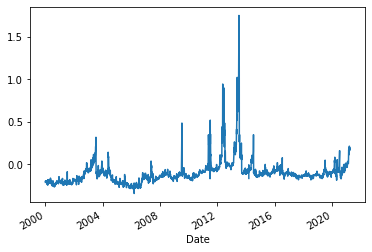

In [22]:
corn_basis.plot()

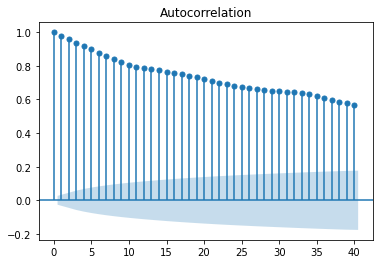

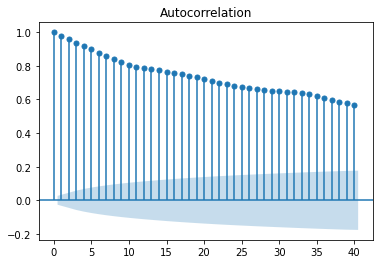

In [37]:
plot_acf(corn_basis.dropna().values.squeeze(), lags=40)

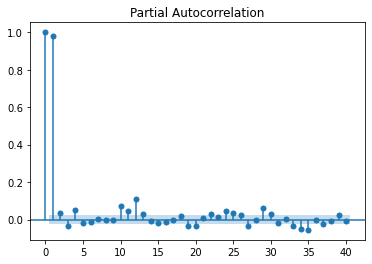

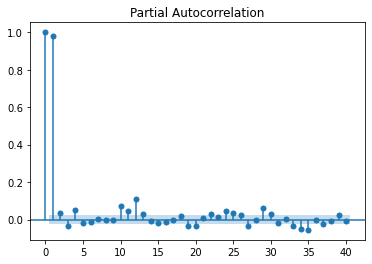

In [38]:
plot_pacf(corn_basis.dropna().values.squeeze(), lags=40)

In [42]:
monthly_corn_basis = corn_basis.resample('M', convention='end').last()

<AxesSubplot:xlabel='Date'>

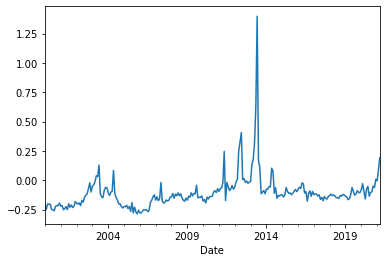

In [43]:
monthly_corn_basis.plot()